# ChessBase 2018 small dataset

In [1]:
%matplotlib inline

In [2]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timezone
from kseval.models import iterate_dataset
from kseval.models.chess import EloModel, TrueSkillModel, DATASET
from kseval.utils import data_path
from math import log

## Summary statistics

In [3]:
counter = collections.Counter()
n_obs = 0
for obs in iterate_dataset(DATASET):
    counter[obs["white"]] += 1
    counter[obs["black"]] += 1
    n_obs += 1

In [4]:
print("number of observations: {:,}".format(n_obs))
print("number of players:      {:,}".format(len(counter)))

number of observations: 306,764
number of players:      19,788


Text(0.5, 0, 'player ID')

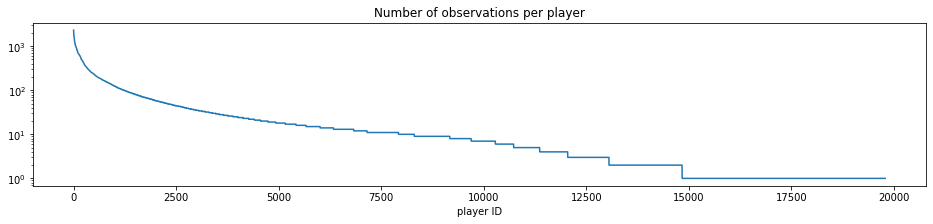

In [5]:
fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.semilogy(sorted(counter.values(), reverse=True))
ax.set_title("Number of observations per player")
ax.set_xlabel("player ID")

In [6]:
ts = list()
counter = collections.Counter()
for obs in iterate_dataset(DATASET):
    dt = datetime.fromtimestamp(obs["t"], tz=timezone.utc)
    counter[dt.year] += 1
    ts.append(obs["t"])

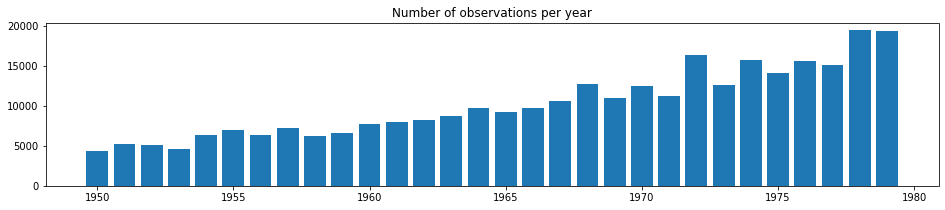

In [7]:
begin, end = min(counter), max(counter)
indices = np.arange(begin, end + 1, dtype=int)
counts = [counter[y] for y in indices]

fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.bar(indices, counts)
ax.set_title("Number of observations per year");

In [8]:
idx = int(0.7 * len(ts))
dt = datetime.fromtimestamp(ts[idx], tz=timezone.utc)
CUTOFF = datetime(dt.year, dt.month, dt.day, tzinfo=timezone.utc)

print("cutoff date: {:%Y-%m-%d}".format(CUTOFF))

cutoff date: 1974-04-15


## Evaluation of models

Elo

In [9]:
%%time
model = EloModel(margin=0.856, lr=0.158)
model.fit(cutoff=CUTOFF)
elo = model.evaluate(begin=CUTOFF)

CPU times: user 5.38 s, sys: 44.1 ms, total: 5.42 s
Wall time: 5.42 s


TrueSkill

In [10]:
%%time
model = TrueSkillModel(margin=0.555, sigma=0.490, tau=0.030)
model.fit(cutoff=CUTOFF)
trueskill = model.evaluate(begin=CUTOFF)

CPU times: user 2min 4s, sys: 314 ms, total: 2min 4s
Wall time: 2min 5s


In [11]:
res = {"random": {
    "n_obs": 0,
    "avg_ll": log(3),
    "avg_acc": 1/3
}}

for model, x in (("elo", elo), ("trueskill", trueskill)):
    res[model] = {
        "n_obs": x[0],
        "avg_ll": x[1] / x[0],
        "avg_acc": x[2] / x[0],
    }

for model in ("constant", "matern12", "matern32", "matern52", "ttt", "wiener", "kl", "wa"):
    n_obs, log_loss, accuracy = 0, 0.0, 0.0
    for datum in iterate_dataset("eval/chess-{}.txt".format(model)):
        n_obs += datum["n_obs"]
        log_loss += datum["log_loss"]
        accuracy += datum["accuracy"]
    res[model] = {
        "n_obs": n_obs,
        "avg_ll": log_loss / n_obs,
        "avg_acc": accuracy / n_obs,
    }

# Save results for plots.
with open(data_path("fig/chess-small-perf.json"), "w") as f:
    json.dump(res, f)

    with open(data_path("fig/chess-small-perf.json")) as f:
        res = json.load(f)
        
### Results for dynamics

In [12]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <9}  {: >5}    {:.3f}     {:.3f}"

for model in ("random", "elo", "trueskill", "constant", "matern12",
        "matern32", "matern52", "ttt", "wiener"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random         0    1.099     0.333
elo        92044    1.035     0.447
trueskill  92044    1.030     0.467
constant   92044    1.030     0.478
matern12   92044    1.026     0.480
matern32   92044    1.026     0.478
matern52   92044    1.026     0.478
ttt        92044    1.026     0.475
wiener     92044    1.026     0.474


Best model:

- in terms of marginal log-likelihood: Wiener
- in terms of predictive log-loss: Matern12

### Results for variational objective

In [13]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <9}  {: >5}    {:.3f}     {:.3f}"

for model in ("random", "wiener", "kl"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random         0    1.099     0.333
wiener     92044    1.026     0.474
kl         92044    1.026     0.474


### Results for white-advantage

In [14]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <9}  {: >5}    {:.3f}     {:.3f}"

for model in ("random", "matern12", "wa"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random         0    1.099     0.333
matern12   92044    1.026     0.480
wa         92044    1.019     0.485
